# Step-by-step instruction tuning for zero-shot slot identification

## Data preparation




* Upload your file

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

import pandas as pd

data = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/nlu_raw.tsv", delimiter="\t")
data



> Models to test:

*   LLaMantino-2-7b-hf-ITA:https://huggingface.co/swap-uniba/LLaMAntino-2-7b-hf-ITA
*   IT5: https://huggingface.co/gsarti/it5-base
* mt0-xxl-mt: https://huggingface.co/bigscience/mt0-xxl-mt
* flan-t5-base: https://huggingface.co/google/flan-t5-base (or larger models of the same family)
* universal-ner-ita: https://huggingface.co/DeepMount00/universal_ner_ita
* span-marker-bert-base-multilingual-uncased-multinerd: https://huggingface.co/lxyuan/span-marker-bert-base-multilingual-uncased-multinerd?text=qual+%C3%A8+il+momento+migliore+per+avviare+la+lavatrice+considerando+l%27energia+solare+disponibile%3F
(the last two models do not support instruction-tuning; traditional fine-tuning might be necessary)


* Build the prompt following the template model also used in Basile et al. (2023) http://arxiv.org/abs/2312.09993

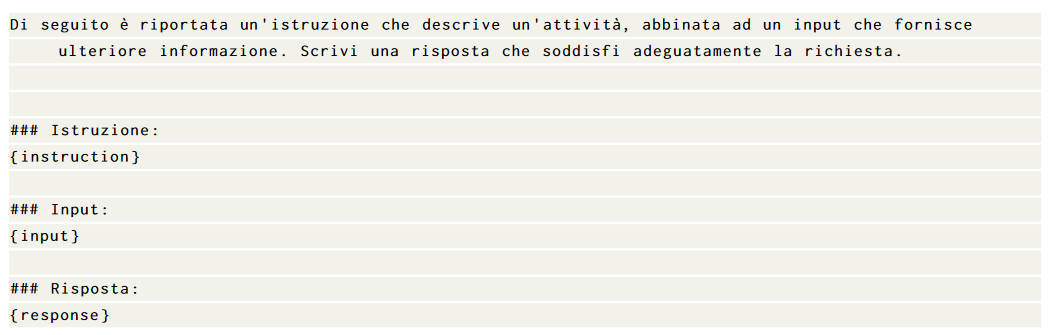

(template version without the response)

In [ ]:
def prepare_data(examples):
  prompts = []
  #primer = "Di seguito è riportata un'istruzione che descrive un'attività, abbinata d un input che fornisce ulteriore informazione. Scrivi una risposta che soddisfi adeguatamente la richiesta. "
  instruction = " Estrai da questo enunciato dell'utente eventuali span di testo che si riferiscono a elettrodomestici, a fonti di energia o a preferenze d'uso dell'utente, e che possono essere utilizzati come slot all'interno di un sistema di dialogo. Se l'enunciato contiente più di uno slot, separali con la virgola; se non contiene nessuno slot, restituisci il simbolo '-'."

  for t, s in zip(examples["text"], examples["slots"]):
    prompt_template = """
                      ### Istruzione: \n {instruction}\n\n
                      ### Input: \n {input}\n\n
                      ### Risposta: \n {response}
                      """
    #filled_in_template = prompt_template.format(primer=primer, instruction=instruction,input=t)
    filled_in_template = prompt_template.format(instruction=instruction,input=t, response=s)
    prompts.append(filled_in_template)

  return prompts

data["prompt"] = prepare_data(data)



*   Convert it into a HuggingFace compatible format using the ```datasets``` library


* Split it into training, validation and test set




In [ ]:
! pip install datasets

In [ ]:
from datasets import Dataset

dataset = Dataset.from_pandas(data)
print(dataset)
dataset_train = dataset.filter(lambda d: d["orig_split"]=="train")
split = dataset_train.train_test_split(test_size=0.2)
train = split["train"]
val = split["test"]
test = dataset.filter(lambda d: d["orig_split"]=="test")
train, val, test



*   Tokenize both partitions using the pre-trained tokenizer associated with the given model to fine-tune (load the data as tensors on a GPU, if available)

In [ ]:
import torch
from transformers import AutoTokenizer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

#tokenizer = AutoTokenizer.from_pretrained("gsarti/it5-base")
#tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-base")
tokenizer = AutoTokenizer.from_pretrained('xlm-roberta-base')

def tokenization_function(data):
  inputs = tokenizer(data["prompt"], padding=True, truncation=True, max_length=200, return_tensors="pt")
  target_slots = tokenizer(data["slots"], padding=True, truncation=True, max_length=5, return_tensors="pt")
  inputs["labels"] = target_slots["input_ids"]

  return inputs


tokenized_train = train.map(lambda t: tokenization_function(t), batched=True)
tokenized_val = val.map(lambda t: tokenization_function(t), batched=True)
tokenized_test = test.map(lambda t: tokenization_function(t), batched=True)

print(tokenized_test)
print(tokenizer.decode(tokenized_test["input_ids"][21]))
print(tokenizer.decode(tokenized_test["labels"][21]))

In [ ]:
from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model="gsarti/it5-base")
#data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model="google/flan-t5-base")

## Training step

* Define an evaluation metric (this one has been adapted from https://huggingface.co/docs/transformers/tasks/summarization)

In [ ]:
! pip install accelerate rouge_score

In [ ]:
import datasets
import numpy as np
from transformers import EvalPrediction
from sklearn.metrics import f1_score, precision_score, recall_score


def eval(predictions, labels):
  decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
  labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
  decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
  rouge = datasets.load_metric("rouge")
  rouge_1 = rouge.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True, rouge_types=["rouge1"])["rouge1"].mid
  precision = precision_score(decoded_labels, decoded_preds, average='micro')
  recall = recall_score(decoded_labels, decoded_preds, average='micro')
  f1 = f1_score(decoded_labels, decoded_preds, average='micro')

  return {"micro-precision": round(precision, 4),
          "micro-recall": round(recall, 4),
          "f1": round(f1, 4),
          "rouge1_fmeasure": round(rouge_1.fmeasure, 4),
        }

def compute_metric(eval_pred: EvalPrediction):
  predictions, labels = eval_pred
  res = eval(predictions, labels)

  return res

#print(compute_metric())

* Define the hyperparameters

In [ ]:
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer
model_name = "flan-t5_slot_id"

batch_size = 4
model_dir = f"/content/gdrive/MyDrive/Colab Notebooks/Models/{model_name}"
args = Seq2SeqTrainingArguments(
    output_dir=model_dir,
    evaluation_strategy="steps",
    eval_steps=10,
    logging_strategy="steps",
    logging_steps=10,
    save_strategy="steps",
    save_steps=10,
    learning_rate=1e-6,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    save_total_limit=1,
    num_train_epochs=3,
    predict_with_generate=True,
    #fp16=True,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
)

print(model_dir)

In [ ]:
from transformers import TrainingArguments, Trainer
model_name = "xlm-roberta"

batch_size = 4
model_dir = f"/content/gdrive/MyDrive/Colab Notebooks/Models/{model_name}"

training_args = TrainingArguments(
    output_dir=model_dir,
    evaluation_strategy="steps",
    eval_steps=10,
    logging_strategy="steps",
    logging_steps=10,
    save_strategy="steps",
    save_steps=10,
    learning_rate=1e-6,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    save_total_limit=1,
    num_train_epochs=3,
    weight_decay=0.01,
)

print(model_dir)

In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from transformers import AutoModelForSequenceClassification, BertForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("xlm-roberta-base").to(device)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val
)

* Load the model and configure the training process

In [ ]:
from transformers import AutoModelForSeq2SeqLM, AutoModelForCausalLM

model_name = "gsarti/it5-base"
#model_name = "google/flan-t5-base"
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

trainer = Seq2SeqTrainer(
    model=model,
    args=args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metric,
)


* Start the training process

In [ ]:

trainer.train()


* Evaluate the trained model on the validation set

In [ ]:
trainer.evaluate()

## Evaluation

* Run the fine-tuned model on the test data

In [ ]:
ft_config=f"{model_dir}/checkpoint-10"
tokenizer = AutoTokenizer.from_pretrained(ft_config)
model = AutoModelForSeq2SeqLM.from_pretrained(ft_config)

def inference(dataset, model, tokenizer):
  inputs = dataset["prompt"]
  input_ids = tokenizer(inputs, return_tensors="pt", max_length=200, truncation=True, padding=True)
  input_ids.to(device)
  output_ids = model.generate(**input_ids, max_length=10)
  output = [tokenizer.decode(ids, skip_special_tokens=True) for ids in output_ids]

  for t, span in zip(dataset["text"], output):
      print(f"{t}: {span}")
  #return output

inference(tokenized_test, model, tokenizer)

* Evaluate results